#W207.5 Group Project

##Nate Black, Vineet Gangwar, Jared Maslin, Malini Mittal

##Kaggle Competition - "Forest Cover Type Prediction"

##MIDS Summer 2015 Term
----

###Section 1: Description of Kaggle Competition (with background and goal)

####Competition Description: Summary and Objective

This competition seeks to predict the forest cover type from strictly cartographic variables. The actual forest cover type for a given 30m x 30m patch was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.      

The dataset was provided by Jock A. Blackard and Colorado State University, and is hosted by UCI machine learning repository.

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. The goal is to predict an integer classification for the forest cover type. 

><strong>Tree Types</strong>  
<em>Spruce/Fir</em>   
<em>Lodgepole Pine</em>   
<em>Ponderosa Pine</em>  
<em>Cottonwood/Willow</em>   
<em>Aspen</em>
<em>Douglas-fir</em>   
<em>Krummholz</em>  

The training set (15120 observations) contains both features and the Cover_Type. The test set contains only the features.

><strong>Data Fields</strong>  
<em>Elevation</em> - Elevation (in meters)  
<em>Aspect</em> - Aspect (in degrees azimuth)  
<em>Slope</em> - Slope (in degrees)  
<em>Horizontal_Distance_To_Hydrology</em> - Horizontal distance to nearest surface water features  
<em>Vertical_Distance_To_Hydrology</em> - Vertical distance to nearest surface water features  
<em>Horizontal_Distance_To_Roadways</em> - Horizontal distance to nearest roadway  
<em>Hillshade_9am (0 to 255 index)</em> - Hillshade index at 9am, summer solstice  
<em>Hillshade_Noon (0 to 255 index)</em> - Hillshade index at noon, summer solstice  
<em>Hillshade_3pm (0 to 255 index)</em> - Hillshade index at 3pm, summer solstice  
<em>Horizontal_Distance_To_Fire_Points</em> - Horizontal distance to nearest wildfire ignition points  
<em>Wilderness_Area</em> (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation  
<em>Soil_Type</em> (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation  
<em>Cover_Type</em> (7 types, integers 1 to 7) - Forest Cover Type Label

----

###Section 2: Data Loading and Exploration

Load the required libraries.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab
import pandas as pd
import seaborn as sns
import os
import csv
from itertools import combinations
from scipy.sparse import csr_matrix, hstack
from math import sqrt
from time import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint as sp_randint
from sklearn.grid_search import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
plot_data = pd.read_csv('train.csv')
plot_labels = plot_data['Cover_Type'].values

#Map tree codes to names
tree_map = {1:'Spruce/Fir',
            2:'Lodgepole Pine',
            3:'Ponderosa Pine',
            4:'Cottonwood/Willow',
            5:'Aspen',
            6:'Douglas-fir',
            7:'Krummholz'}

plot_data['Tree'] = plot_data['Cover_Type'].apply(func = lambda x: tree_map[x])

We saw that the data was evenly distributed across classes in the training data. This is important as we inferred that the test data does <em>not</em> show a similar distribution.

In [3]:
gb = plot_data.groupby(['Tree'])
gb['Id'].count()

Tree
Aspen                2160
Cottonwood/Willow    2160
Douglas-fir          2160
Krummholz            2160
Lodgepole Pine       2160
Ponderosa Pine       2160
Spruce/Fir           2160
Name: Id, dtype: int64

Before looking at algorithms, we plotted variables to explore the data.

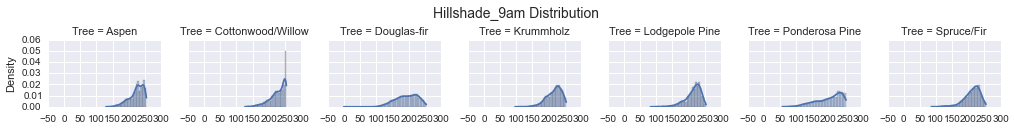

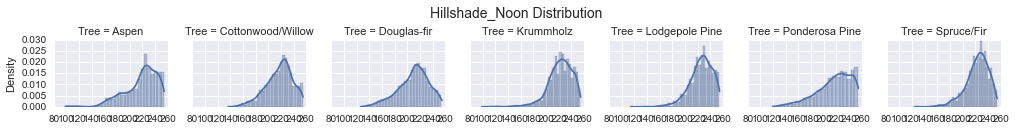

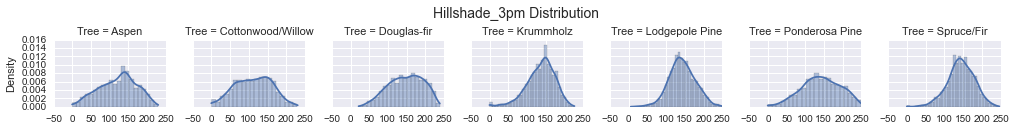

In [4]:
ordinal_columns = ['Hillshade_9am', 
                'Hillshade_Noon', 
                'Hillshade_3pm']

def ord_dist(var):
    items = sns.FacetGrid(plot_data, col = 'Tree', size= 2)
    items.map(sns.distplot, var).set_axis_labels('','Density')
    items.fig.suptitle(var + " Distribution", size = 14)
    plt.subplots_adjust(top=0.75)
    plt.show()

for col in ordinal_columns:
    ord_dist(col)

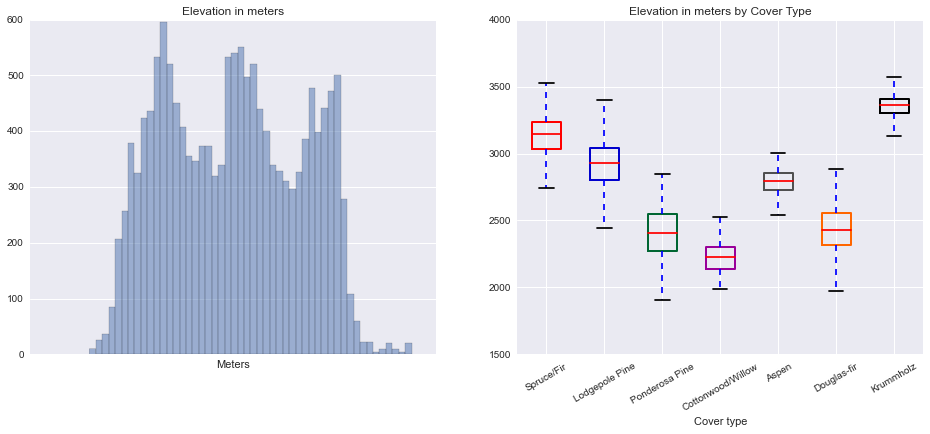

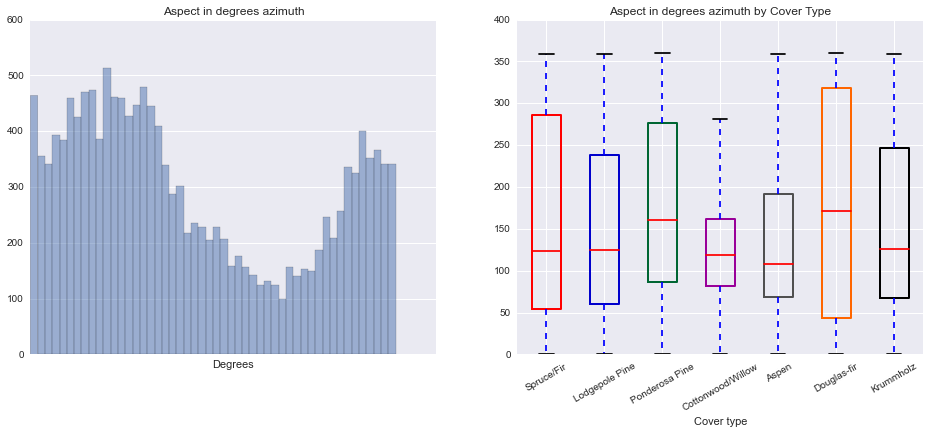

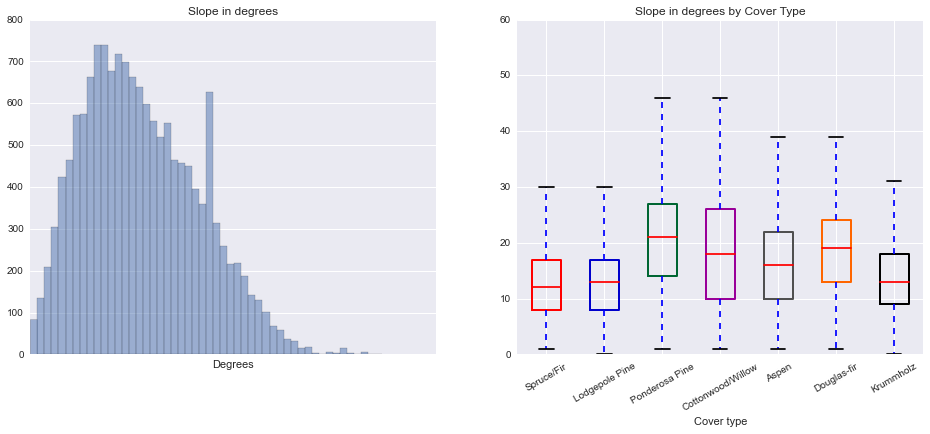

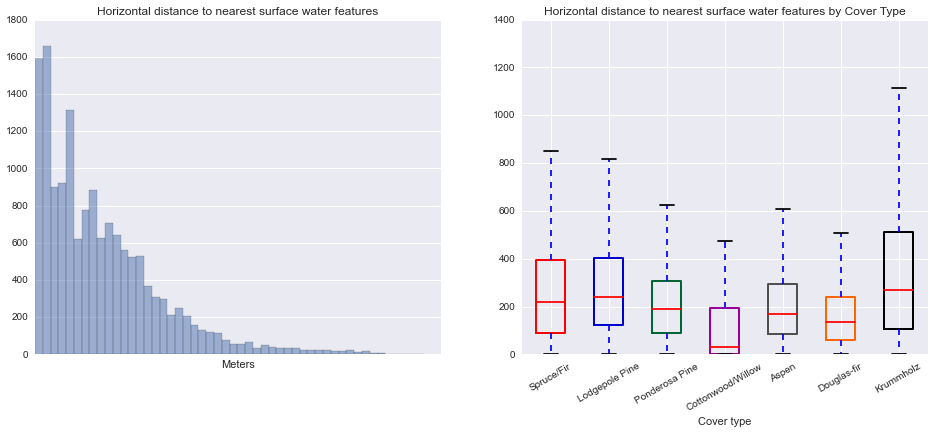

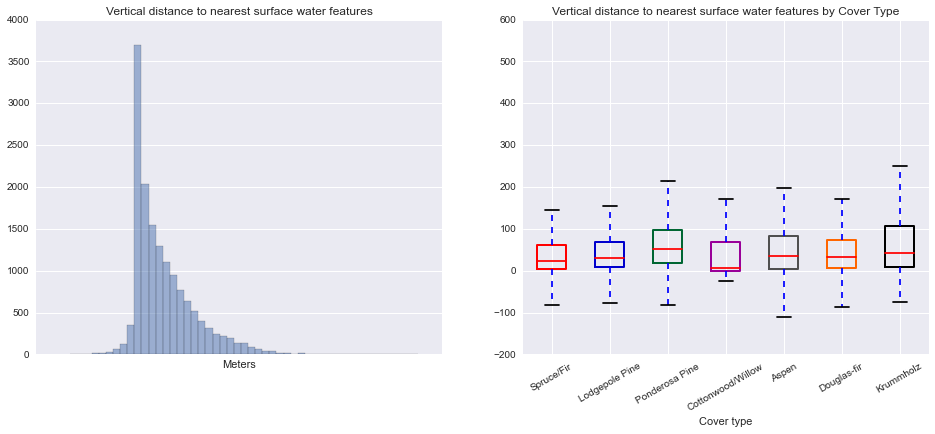

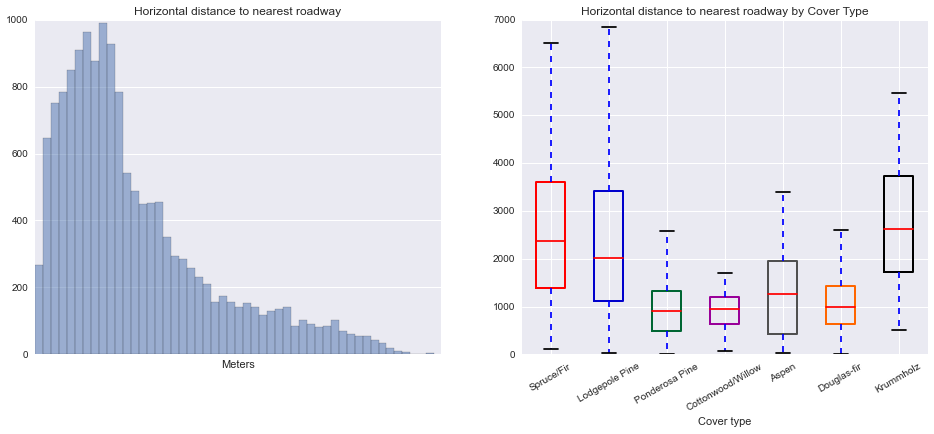

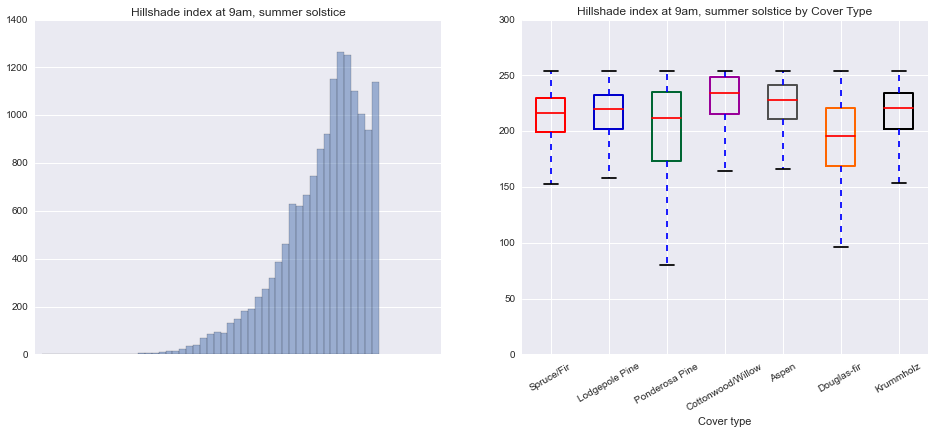

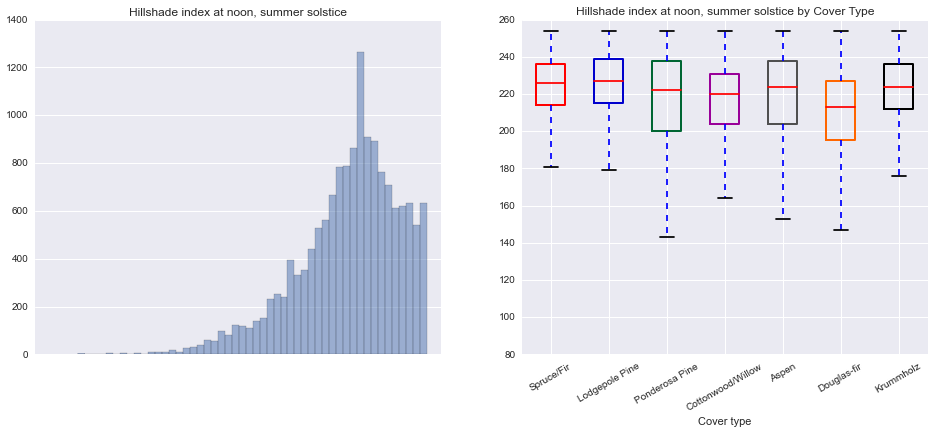

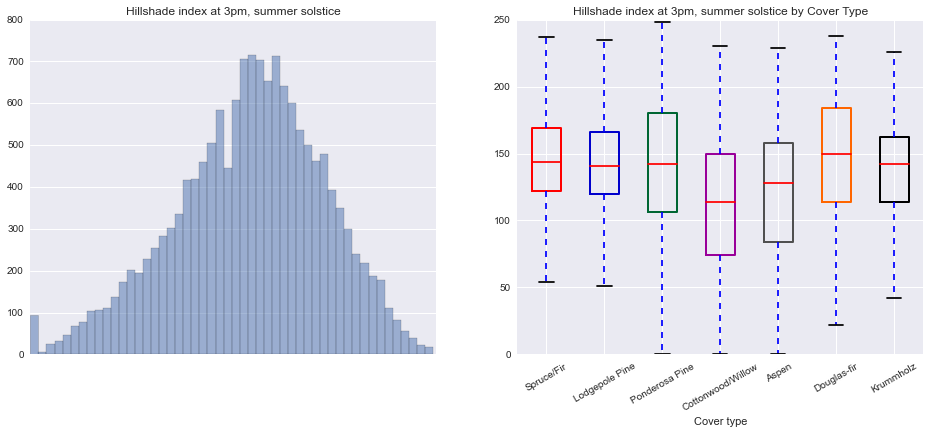

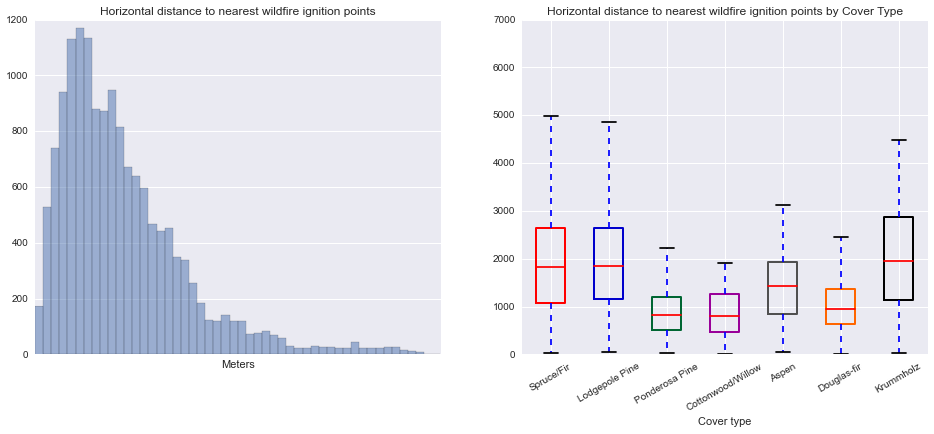

In [5]:
# Visualizing data distributions - Plotting histograms
cover_type = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 
              'Cottonwood/Willow','Aspen', 'Douglas-fir', 'Krummholz']

#Grab some colors for plotting
colors = ["#FF0000", "#0000CC", "#006633", "#990099", "#505050", "#FF6600", "#000000"]

def plot_histogram(ax, data, title, xlab):
    ax.hist(data, bins=50, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_xticks([])
    
def plot_class_wise_data(ax, data, title, labels):
    boxplotdata = list()
    for classes in range(1, 8):
        sub_data = data[np.where(labels == classes)]
        boxplotdata.append(sub_data)

    bp = ax.boxplot(boxplotdata)
    ax.set_xlabel('Cover type')
    ax.set_title(title + ' by Cover Type')
    ax.set_xticklabels(cover_type, rotation=30)

    for i, box in enumerate(bp['boxes']):
        box.set(color=colors[i], linewidth=2)

def plotter(data, labels, title_1, x_label_1):
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    plot_histogram(ax1, data, title_1, x_label_1)
    ax2 = fig.add_subplot(1, 2, 2)
    plot_class_wise_data(ax2, data, title_1, labels)

#Define titles, labels, and variables
titles = ['Elevation in meters', 'Aspect in degrees azimuth', 'Slope in degrees',
          'Horizontal distance to nearest surface water features', 
          'Vertical distance to nearest surface water features',
          'Horizontal distance to nearest roadway', 'Hillshade index at 9am, summer solstice',
          'Hillshade index at noon, summer solstice','Hillshade index at 3pm, summer solstice',
          'Horizontal distance to nearest wildfire ignition points']

labels = ['Meters', 'Degrees', 'Degrees', 'Meters', 'Meters', 'Meters', '', '', '', 'Meters']

variables = [plot_data.Elevation, plot_data.Aspect, plot_data.Slope, plot_data.Horizontal_Distance_To_Hydrology,
             plot_data.Vertical_Distance_To_Hydrology, plot_data.Horizontal_Distance_To_Roadways,
             plot_data.Hillshade_9am, plot_data.Hillshade_Noon, plot_data.Hillshade_3pm,
             plot_data.Horizontal_Distance_To_Fire_Points]

#Plot distribution and boxplots
for var, title, label in zip(variables, titles, labels):
    plotter(var.values, plot_data.Cover_Type.values, title, label)

From the graphs above, we see that elevation shows a clear distinction across classes and may be an important variable. We can also see separation in the slope, distance to roadway, and distance to wildfire variables.

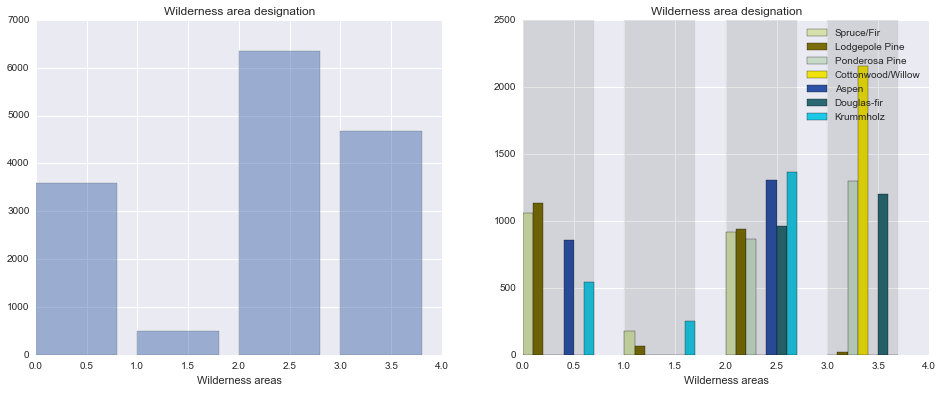

In [6]:
wilderness_area_names = ['Rawah', 'Neota', 'Comanche Peak', 'Cache la Poudre']
plot_wilderness = plot_data[['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']].values

fig = plt.figure(figsize=(16, 6))

cover_type = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 
              'Krummholz']
random_colors = np.random.rand(7, 3)

# Wilderness_Area
wilderness_areas = np.sum(plot_wilderness, axis=0)
ax = fig.add_subplot(1, 2, 1)
dummy = ax.bar(np.arange(4), wilderness_areas, alpha=0.5)
dummy = ax.set_title("Wilderness area designation")
dummy = ax.set_xlabel('Wilderness areas')

# Wilderness_Area per cover type
ax = fig.add_subplot(1, 2, 2)

ind = np.arange(4)
width = 0.1
for i in range(1, 8):
    wilderness_areas = np.sum(plot_wilderness[np.where(plot_labels==i)], axis=0)
    bar = ax.bar(ind, wilderness_areas, width=width, color=random_colors[i-1,:])
    ind = ind + width
    dummy = ax.set_title("Wilderness area designation")
    dummy = ax.set_xlabel('Wilderness areas')
    ax.legend(cover_type)
dummy = ax.set_xlim(0, 4)
bar = ax.bar(np.arange(4), [2500, 2500, 2500, 2500], width=(width*7), color='black', alpha=0.1)

----

###Section 3: Creating a Baseline Model for Kaggle  

Establish a baseline score in Kaggle using basic KNN model where K = 1

In [7]:
#Load the training data
full_train_data = pd.read_csv('train.csv', header=0) 
full_train_labels = full_train_data['Cover_Type']
full_train_id = full_train_data['Id']
full_train_data.drop(['Cover_Type', 'Id'], axis=1, inplace=True) 

#Load the test data
full_test_data = pd.read_csv('test.csv', header=0) 
full_test_id = full_test_data['Id']
full_test_data.drop(['Id'], axis=1, inplace=True) 

#Fit KNN
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(full_train_data.values, full_train_labels.values)

#Create Predictions and export to CSV
predictions = knn.predict(full_test_data.values).astype(int) 
submission = pd.DataFrame(full_test_id, columns = ['Id'])
submission['Cover_Type'] = predictions
submission.to_csv("sampleSubmissionKNN1.csv", index = False, index_col = False)

<strong>This baseline yields a Kaggle score of 0.71016 (leaderboard rank = 1175)</strong>  
   
Now plot the predictions above to get a sense of the distribution.

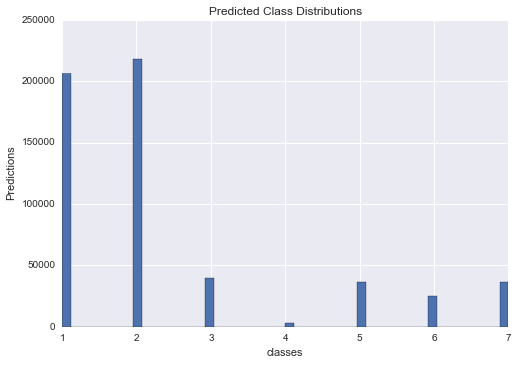

In [8]:
plt.hist(predictions, 50)
plt.xlabel('classes')
plt.ylabel('Predictions')
plt.title('Predicted Class Distributions')
plt.show()

This distribution leads us to believe that the test data has a higher concentration of class 1 and class 2 trees, as we predicted mostly 1 and 2 and received a score of ~75%.

----
###Section 4: Run baseline models for comparison
To do this, we will need to create a development (validation) set out of the training data provided. This splitting will allow for us to test several classifiers at a high level before selecting the most insightful classifier for further definition.   
   
We will be using the development data for cross-validation from now on until the end.

In [9]:
#Shuffle the data
X = full_train_data.values
Y = full_train_labels.values
shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

#Split the data into training and development sets
train_data, dev_data, train_labels, dev_labels = train_test_split(X, Y, test_size=0.2, random_state=0)

In [10]:
#Baseline K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(train_data, train_labels)
print 'K-Nearest Neighbors yields an accuracy of %.2f%%' % (knn.score(dev_data, dev_labels)*100)

#Baseline Linear Regression
lr = LinearRegression() 
lr.fit(train_data, train_labels)
print '\nLinear Regression yields an accuracy of %.2f%%' % (lr.score(dev_data, dev_labels)*100)

#Baseline Logistic Regression
lm = LogisticRegression() 
lm.fit(train_data, train_labels)
print '\nLogistic Regression yields an accuracy of %.2f%%' % (lm.score(dev_data, dev_labels)*100)

#Baseline Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(train_data, train_labels)
print '\nGaussian Naive Bayes yields an accuracy of %.2f%%' % (gnb.score(dev_data, dev_labels)*100)

#Baseline Random Forest
rf = RandomForestClassifier()
rf.fit(train_data, train_labels)
print '\nRandom Forest yields an accuracy of %.2f%%' % (rf.score(dev_data, dev_labels)*100)

#Baseline "ExtraTrees"
et = ExtraTreesClassifier()
et.fit(train_data, train_labels)
print '\nExtra Trees yields an accuracy of %.2f%%' % (et.score(dev_data, dev_labels)*100)

K-Nearest Neighbors yields an accuracy of 79.79%

Linear Regression yields an accuracy of 41.85%

Logistic Regression yields an accuracy of 67.00%

Gaussian Naive Bayes yields an accuracy of 47.55%

Random Forest yields an accuracy of 83.04%

Extra Trees yields an accuracy of 84.03%


One surprise that pops out is the relative accuracy for KNN model (where K = 1) with respect to regressions and Naive Bayes. That said, both Random Forest and Extra Trees produce slightly superior results. 

With this initial validation complete, we will move forward with further developing a model based on the Extra Trees classifier. Random Forest/Extra Trees seem appropriate as there appear to be breakpoints in some of the variables and a decision tree seems apt to find these breakpoints.

In [11]:
def show_confusion_matrix(cf, title):
    conf_arr = cf.tolist()
    norm_conf = []
    for i in conf_arr:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            if a == 0:
                tmp_arr.append(0)
            else:
                tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)
    cmap = sns.light_palette('green', as_cmap = True)
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap=cmap, interpolation='nearest')

    width = len(conf_arr)
    height = len(conf_arr[0])

    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        weight='bold')
    
    plt.title(title, weight='bold')
    plt.ylabel('Actual Category', style='italic')
    plt.xlabel('Predicted Category',style='italic')
    items = [1,2,3,4,5,6,7]
    plt.xticks(range(width), items)
    plt.yticks(range(height), items)
    plt.grid(b = None)
    
def print_diagnostics(true_labels, pred_labels, title):
    print 'Classification report:'
    print classification_report(dev_labels, predictions)
    cf = confusion_matrix(dev_labels, predictions)
    show_confusion_matrix(cf, title)

Classification report:
             precision    recall  f1-score   support

          1       0.74      0.74      0.74       438
          2       0.74      0.65      0.69       432
          3       0.79      0.79      0.79       419
          4       0.91      0.96      0.93       437
          5       0.88      0.93      0.91       439
          6       0.83      0.80      0.82       439
          7       0.93      0.96      0.94       420

avg / total       0.83      0.83      0.83      3024



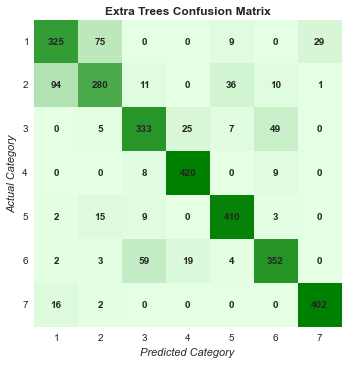

In [12]:
et = ExtraTreesClassifier()
et.fit(train_data, train_labels)

predictions = et.predict(dev_data).astype(int)
print_diagnostics(dev_labels, predictions, 'Extra Trees Confusion Matrix')

   
The confusion matrix shows that the classifier is performing well across most classes but is having difficult distinguishing the first and second classes. 

----

<strong>Contour plot of bivariate distribution of continous variables for Cover_Type 1 and Cover_Type 2</strong>  
As the confusion matrix above shows that the classifier seems to be having the most trouble classifying Cover_Type 1 and Cover_Type 2, we investigated the data some more. Below we show the contour plots of bivariate distribution. The 21 rows of plots show how similar Cover_Type 1 and Cover_Type 2 really are.

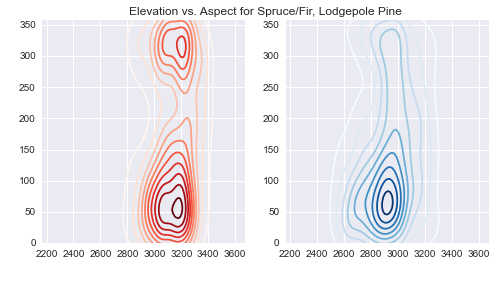

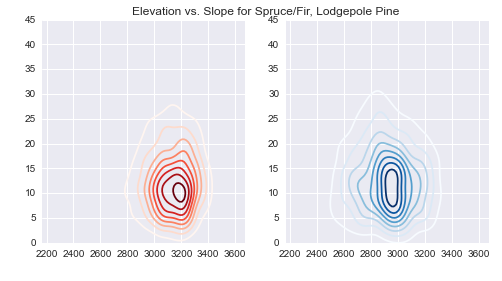

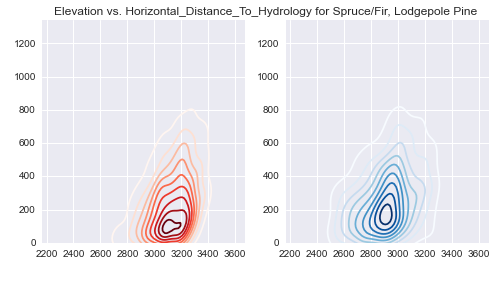

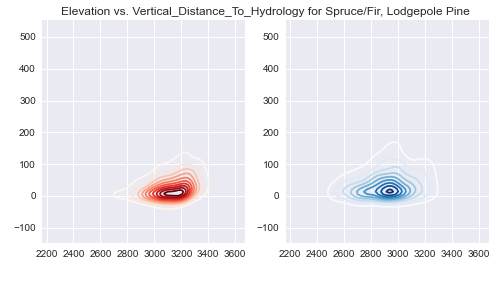

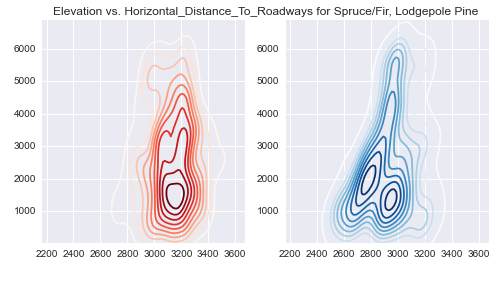

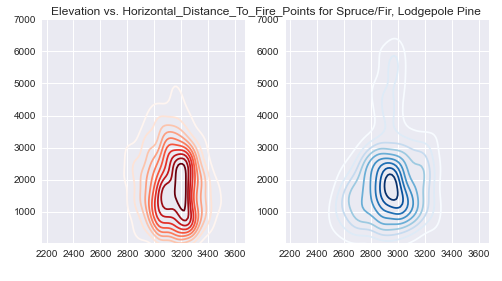

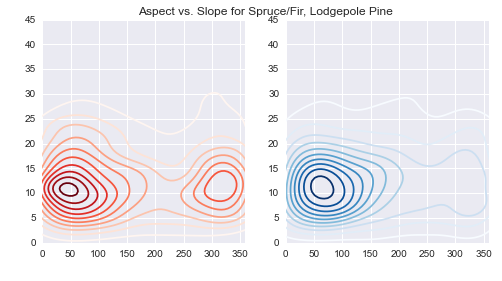

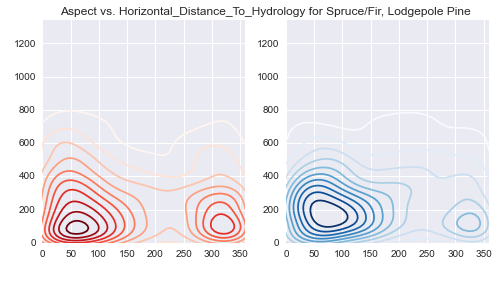

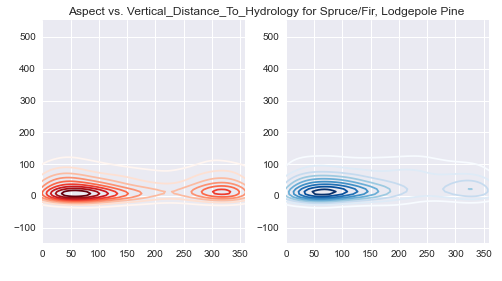

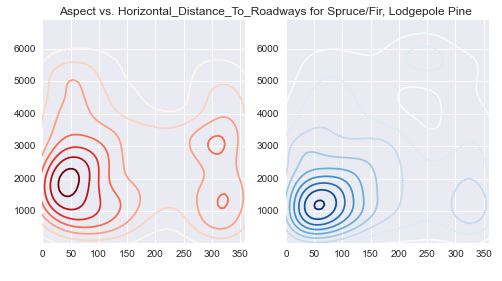

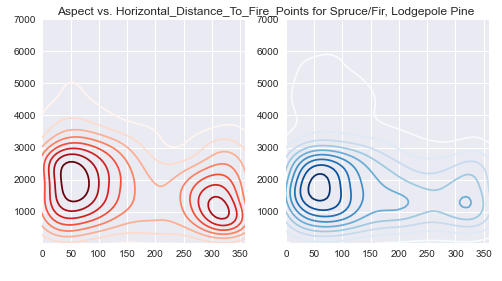

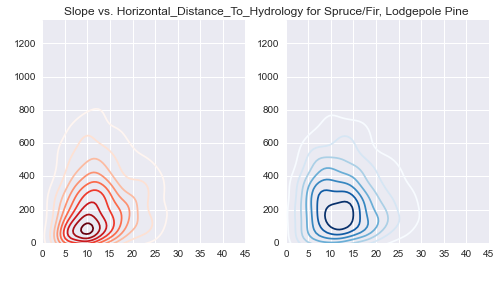

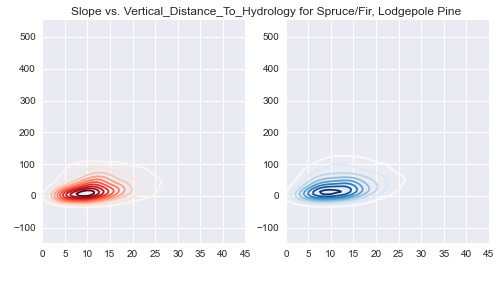

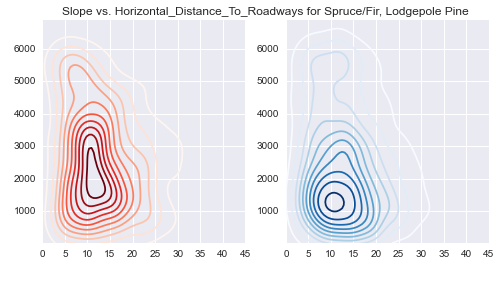

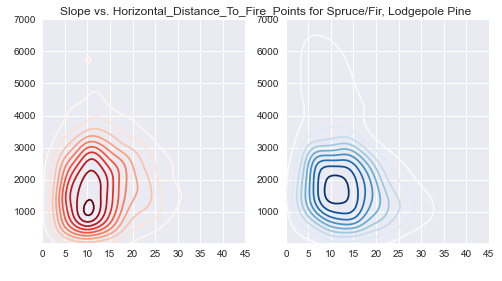

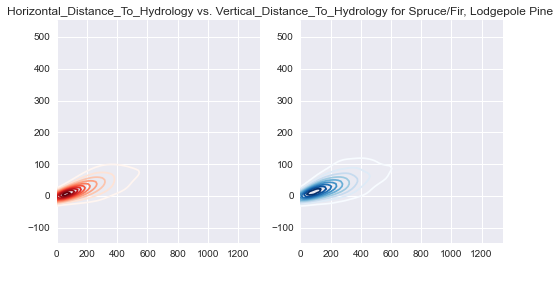

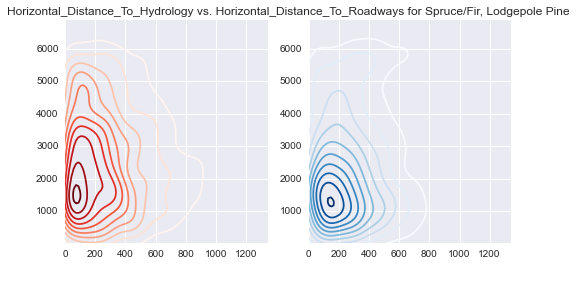

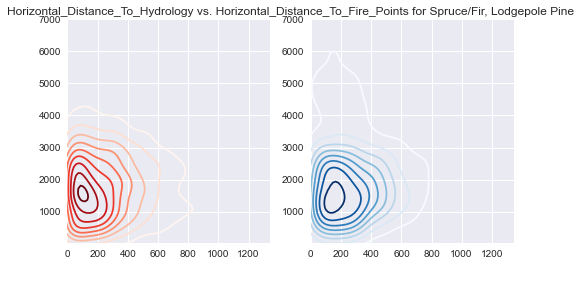

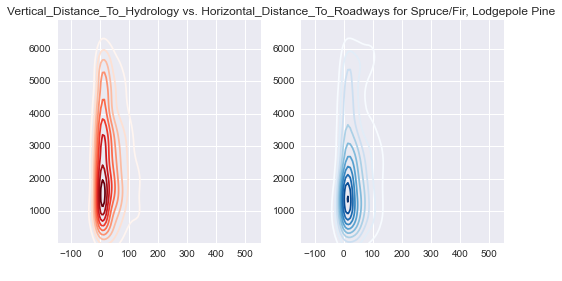

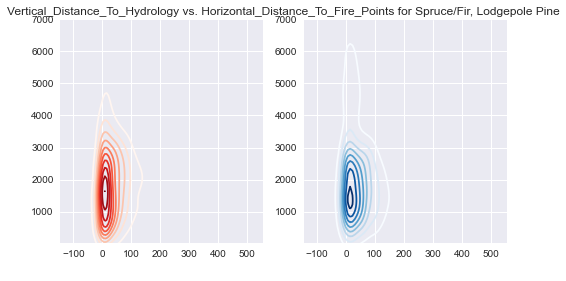

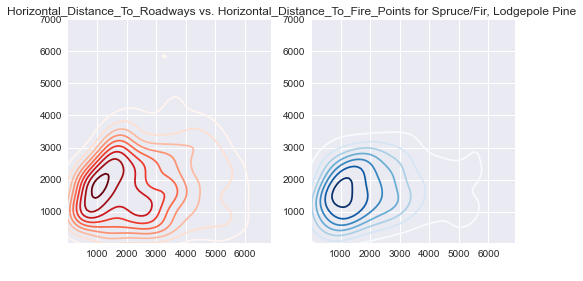

In [13]:
# Subseting data on Cover_Types 1 and 2
cover_type_1 = plot_data[plot_data['Cover_Type']==1]
cover_type_2 = plot_data[plot_data['Cover_Type']==2]
cover_type_1_and_2 = pd.concat([cover_type_1, cover_type_2], ignore_index=True)

# Continous features
contin_col = ['Elevation',
                'Aspect', 
                'Slope',
                'Horizontal_Distance_To_Hydrology', 
                'Vertical_Distance_To_Hydrology', 
                'Horizontal_Distance_To_Roadways', 
                'Horizontal_Distance_To_Fire_Points']

subset_cover_types = ['Spruce/Fir', 'Lodgepole Pine']

def bivariate_dist(var1, var2, data):
    f = plt.figure(figsize=(8, 4))
    plt.title(var1 + " vs. " + var2 + " for " + ", ".join(subset_cover_types))
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.axis('off')
    colors = ["Reds", "Blues"]
    for indx, tree in enumerate(subset_cover_types):
        df = data[data['Tree'] == tree]
        f.add_subplot(1,2,indx+1)
        sns.kdeplot(df[var1].values, df[var2].values, cmap=colors[indx], shade=False, shade_lowest=False)
        pylab.xlim([data[var1].min(),data[var1].max()])
        pylab.ylim([data[var2].min(),data[var2].max()])
    plt.show();

contin_var_comb = combinations(contin_col, 2)

for pair in contin_var_comb:
    var1, var2 = pair
    bivariate_dist(var1, var2, cover_type_1_and_2)

###Section 5: Feature Engineering and Parameter/Model Tuning

Something that we've seen in our error analysis throughout this exercise is that while the training data possesses an even split of observations between the seven cover_types, the test dataset possesses an overwhelming percentage of Cover_Type 1 and 2, over others (3 through 7). 

To address this, we can attempt to de-skew the data by searching for target weights amongst the cover types. By using a simple classifier (like KNN) and running for a few iterations in order to estimate feature weights across each run, we may be able to form a more generalizable expectation of cover_type distribution.

In [14]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(full_train_data.values, full_train_labels.values)

#create a zero array to hold target weights
weights = np.zeros(7)
test_todense = full_test_data.values

#iterate 5 times:
#extract a random subset of test data
#predict the KNN target value
#add the target weights to the weights array
for i in range(5):
    test_subset = test_todense[np.random.choice(test_todense.shape[0],10000)] #get a random 10000 example subset
    weights = weights + np.bincount(knn.predict(test_subset))[1:]
    
#create a target weights dictionary with the average predicted weights
weights = weights / 5.0 #average weights
weight_dict = {i+1:weights[i]/np.sum(weights) for i in range(len(weights))} #dictionary of normalized average weights

print "Class Weights to Account for Skew"
print "=" * 35
for cls, wt in weight_dict.items():
    print "Class: %d\tWeight: %.2f%%" % (cls, wt * 100)

del test_todense

#With this code in place, we can add the attribute "class_weight=weight_dict" within our ExtraTreesClassifier

Class Weights to Account for Skew
Class: 1	Weight: 36.28%
Class: 2	Weight: 38.60%
Class: 3	Weight: 7.24%
Class: 4	Weight: 0.47%
Class: 5	Weight: 6.39%
Class: 6	Weight: 4.53%
Class: 7	Weight: 6.48%


----

The following sections briefly describe features that were derived and the rationale behind each feature.  

<strong>Feature Engineering - Sunlight/Energy received by a 30 by 30 patch </strong>  

The idea behind this feature is that different trees respond differently to different amounts of sunlight/energy.

The dataset provides values of Hillshade for every patch at 9 am, 12 noon and 3 pm. Hillshade is a measure of sunlight incident upon a patch. It has values between 0 and 255 where 0 represents absence of sunlight. Hillshade takes into account Sun's elevation, latitude, slope and aspect of the patch.

This engineered feature indicates the relative amount of sunlight/energy a patch receives. The assumption is that amount of sunlight is more directly correlated to Cover_Type than individual measures of Hillshade and hence is a better predictor. The amount of sunlight is calculated as area under the curve of the below figure.

This figure below is a simplification of the curve because it is not a linear function. But despite the simplification we get an increase in accuracy.

To calculate the area, we measured time in seconds, which is shown below as 10,800 seconds (amount of seconds in a 3-hour period).

After calculating the energy feature, we drop the original hillshade features.

\begin{equation}
\begin{split}
Energy &= \left(\frac{Hillshade9AM + Hillshade12PM}{2} \cdot 10,800\right) + \left(\frac{Hillshade12PM + Hillshade3PM}{2} \cdot 10,800\right)
\end{split}
\end{equation}

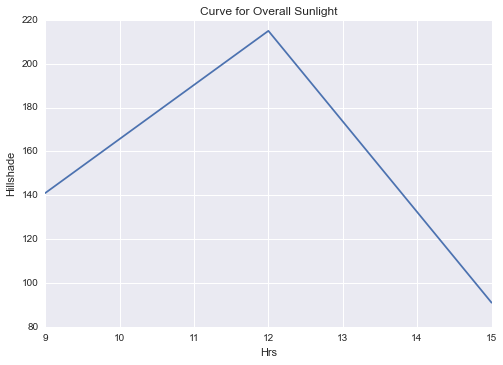

In [15]:
plt.figure() 
hillshade = [141, 215, 91]        # Hillshade values at 9 am, 12 noon and 3 pm
time = [9, 12, 15]                # Time at 9 am, 12 noon and 3 pm
plt.plot([9, 12, 15], [141, 215, 91])
plt.xlabel('Hrs')
plt.ylabel('Hillshade')
plt.title('Curve for Overall Sunlight');

<strong>Feature Engineering - Is patch closer to Roadway and Firepoint than water </strong>

The idea behind these features is that hydrology affect on trees wil be impacted if human effects (Roadways) and natural hazards (fires) are nearby.
These features indicate if roadways and fire points are closer to a patch than hydrology.
These features have improved accuracy and made intuitive sense.

<strong>Feature Engineering - Vertical to Water</strong>

This transformation combines elevation and the vertical distance to water features. The rationale is that impact of vertical distance to water changes relative to the elevation.

<strong>Feature Engineering - Horizontal to Water</strong>

This feature combines elevation and the horizontal distance to water features. The rationale is that impact of vertical distance to water changes relative to the elevation, as a greater distance may have to rely more heavily on slope to maintain water supply for certain types of trees.

<strong>Feature Engineering - Above Patch Level </strong>

This simple transformation indicates if the distance from a tree to the nearest water source is above or below the level of the tree. This is shown through either a positive or negative value for the "vertical distance to water" feature, where a positive value means that the tree/observation is (vertically) above the level of the nearest water source (computed as the the elevation in meters minus the vertical distance to water).

<strong>Feature Engineering - Pythagorean to Water</strong>

This transformation combines horizontal and vertical water distances using the Pythagorean theorem. It triangulates the nearest water supply. This could be important in cases where vertical and horizontal distances to water are very different and looking at the individual features would not pick this up.

<strong>Feature Engineering - Water and Fire </strong>

This feature is intended to capture instances where the nearest water source and fire source are on opposite sides of each tree observation, which can impact the residual effect of either one or both features as distance between them increases.

<strong>Feature Engineering - Water Less Fire</strong>

This transformation emphasizes on the relative position of the tree with respect to water and fire point. Water being closer than the fire point could mean better growth conditions for some trees; for hardy trees, it might not matter.

<strong>Feature Engineering - Water and Roadway </strong>

This feature is intended to capture instances where the nearest water source and roadways are on opposite sides of each tree observation, which can impact the residual effect of either one or both features as distance between them either increases or decreases. In addition, roadways form barriers that can prevent things like water and fire from reaching plants on the opposite side.

<strong>Feature Engineering - Water Less Roadway </strong>

This tries to capture the fact that a roadway changes the natural pattern of water flow. 

<strong>Feature Engineering - Fire and Roadway</strong>

This feature is intended to capture instances where the nearest fire source and the nearest roadway are on opposite sides of an observation, which can impact the residual effect of either one or both features as distance between them either increases or decreases. In addition, roadways form barriers that can prevent things like water and fire from reaching plants on the opposite side.

<strong>Feature Engineering - Fire Less Roadway </strong>

A roadway could provide a barrier for fire, providing some protection to trees which are on the opposite of the raodway as compared to the fire point.

<strong>Feature Engineering - Creating features to differentiate Cover_Types 1 and 2 </strong>

The test data is unusual because it is heavily skewed towards Cover_Types 1 and 2. Additionally, train data shows that these two cover types are very similar.
Plot of data demonstrates this:
- The box plots of features by Cover_Types at the start of section 2
- The contour plots of bivariate distribution of continous variables for Cover_Types 1 and 2 at the end of section 4   
  
To induce variation in the data, we have added two extra features by multiplying features together. Multiplication will amplify the variation.

\begin{equation}
\begin{split}
ExtraFeature1 &=  Slope \cdot HorizontalDistanceToHydrology \cdot VerticalDistanceToHydrology \\
ExtraFeature2 &=  HorizontalDistanceToFire \cdot HorizontalDistanceToRoadways
\end{split}
\end{equation}

<strong> Feature Engineering - Grouping like-terms for Soil Types </strong>

From the data description at https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info, we find that the soil type (which is a four-digit ID) can be split into two sections. One section is an arbitrary ID code to aid the original data gatherers. The first two digits, though, represents a specific grouping of tree types based on the soil. 

With this in mind, we can map the original 40 soil types to actual 11 types.

In [16]:
#Helper function to group soil types
def group_soil_types(*args):
    return np.where(np.sum(args, axis = 0) > 0, 1, 0)

def convert_soil_types(fr):
    #Soil types 1, 2, 3, 4, 5, and 6 are grouped together
    fr['new_soil_1'] = group_soil_types(fr['Soil_Type1'], fr['Soil_Type2'], fr['Soil_Type3'],
                       fr['Soil_Type4'],fr['Soil_Type5'],fr['Soil_Type6']) 
    
    #Soil types 7 & 8 are grouped together
    fr['new_soil_2'] = group_soil_types(fr['Soil_Type7'], fr['Soil_Type8'])
    
    #Soil type 9 is it's own group
    fr['new_soil_3'] = fr['Soil_Type9']
    
    #Soil types 10, 11, 12, 13
    fr['new_soil_4'] = group_soil_types(fr['Soil_Type10'], fr['Soil_Type11'], fr['Soil_Type12'], fr['Soil_Type13'])
    
    #Soil types 14 & 15 are grouped together
    fr['new_soil_5'] = group_soil_types(fr['Soil_Type14'], fr['Soil_Type15'])

    #Soil types 16 & 17 are grouped together
    fr['new_soil_6'] = group_soil_types(fr['Soil_Type16'], fr['Soil_Type17'])
    
    #Soil type 18 is it's own group
    fr['new_soil_7'] = fr['Soil_Type18']
    
    #Soil type 19, 20, & 21 are grouped
    fr['new_soil_8'] = group_soil_types(fr['Soil_Type19'], fr['Soil_Type20'], fr['Soil_Type21'])
    
    #Soil type 19, 20, & 21 are grouped
    fr['new_soil_9'] = group_soil_types(fr['Soil_Type22'], fr['Soil_Type23'])
    
    #Soil type 24-34 are grouped together
    fr['new_soil_10'] = group_soil_types(fr['Soil_Type24'], fr['Soil_Type25'],fr['Soil_Type26'], fr['Soil_Type27'], 
                                       fr['Soil_Type28'], fr['Soil_Type29'],fr['Soil_Type30'], fr['Soil_Type31'], 
                                       fr['Soil_Type32'], fr['Soil_Type33'],fr['Soil_Type34'])
    
    #Soil type 35-40 are grouped together
    fr['new_soil_11'] = group_soil_types(fr['Soil_Type35'], fr['Soil_Type36'],fr['Soil_Type37'], fr['Soil_Type38'], 
                                         fr['Soil_Type39'], fr['Soil_Type40'])
                                         
    return fr


<strong>Azimuth Adjustment</strong>

This adjustment to the existing cartographical feature is intended to reduce the existing “aspect” values, which originally holds values between 0 and 360 (in degrees). This compression can occur as a result of the symmetry that exists between measures from 0 – 180 and 181 – 360, respectively. For example, we would expect symmetry to occur in observations with azimuth of 1 degree and 181 degrees, and likewise, symmetry in observations with azimuth of 90 degrees and 270 degrees. With this in mind, we will reduce any values of x where (x >= 180) to be (x – 180), while any values of (x < 180) remain as (x).

In [17]:
#Azimuth Adjustment
def adjust(x): 
    if x > 180: 
        return x - 180
    else: 
        return x 

In [18]:
def feature_engineering(data_to_tranform):

    data = data_to_tranform.copy()
    data = convert_soil_types(data)
    data['Energy'] = ((data['Hillshade_9am']+data['Hillshade_Noon'])/2)*10800 + \
                        ((data['Hillshade_Noon']+data['Hillshade_3pm'])/2)*10800
    data.drop(['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm'] , axis=1, inplace=True)
    data['Aspect2'] = data.Aspect.map(adjust) 
    data['Vertical_To_Water'] = data.Elevation-data.Vertical_Distance_To_Hydrology 
    data['Horizontal_To_Water'] = data.Elevation-data.Horizontal_Distance_To_Hydrology*0.2 
    data['Above_Patch_Level'] = data.Vertical_Distance_To_Hydrology < 0 
    data['Pythagorean_To_Water'] = (data['Horizontal_Distance_To_Hydrology']**2+data['Vertical_Distance_To_Hydrology']**2)**0.5 
    data['Water_And_Fire'] = data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Fire_Points'] 
    data['Water_Less_Fire'] = (data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Fire_Points']) 
    data['Water_And_Roadway'] = (data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Roadways']) 
    data['Water_Less_Roadway'] = (data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Roadways']) 
    data['Fire_And_Roadway'] = (data['Horizontal_Distance_To_Fire_Points']+data['Horizontal_Distance_To_Roadways']) 
    data['Fire_Less_Roadway'] = (data['Horizontal_Distance_To_Fire_Points']-data['Horizontal_Distance_To_Roadways']) 
    data['Is_Roadway_Closer_than_Water'] = (data['Horizontal_Distance_To_Roadways'] < data['Horizontal_Distance_To_Hydrology'])
    data['Is_Firepoint_Closer_than_Water'] = (data['Horizontal_Distance_To_Fire_Points'] < data['Horizontal_Distance_To_Hydrology'])
    
    #Feature Engineering - Product-based features
    data['Extra_1'] = data['Slope'] * data['Horizontal_Distance_To_Hydrology'] * data['Vertical_Distance_To_Hydrology']
    data['Extra_2'] = data['Horizontal_Distance_To_Fire_Points'] * data['Horizontal_Distance_To_Roadways'] 
    return data

In [19]:
# Add the new features

full_train_data_engd = feature_engineering(full_train_data)
full_test_data_engd = feature_engineering(full_test_data)

#Shuffle the data
np.random.seed(1)
X = full_train_data_engd.values
Y = full_train_labels.values
shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

#Split the data into training and development sets
train_data, dev_data, train_labels, dev_labels = train_test_split(X, Y, test_size=0.2, random_state=0)

Classification report:
             precision    recall  f1-score   support

          1       0.80      0.80      0.80       464
          2       0.81      0.73      0.77       429
          3       0.87      0.88      0.88       413
          4       0.93      0.98      0.95       405
          5       0.93      0.97      0.95       440
          6       0.90      0.87      0.89       428
          7       0.95      0.97      0.96       445

avg / total       0.88      0.89      0.88      3024



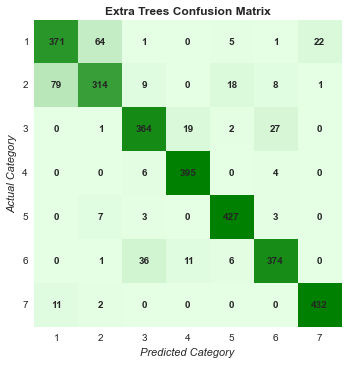

In [20]:
#Let's run the basic ExtraTrees model (un-optimized, as we have not run a grid search yet) 
#using the previously established features and parameter tuning:

clf = ExtraTreesClassifier(class_weight = weight_dict)
clf = clf.fit(train_data, train_labels)
predictions = clf.predict(dev_data).astype(int)

print_diagnostics(dev_labels, predictions, 'Extra Trees Confusion Matrix')

The classification for classes 1 and 2 has improved due to the various new features.   

Classification report:
             precision    recall  f1-score   support

          1       0.80      0.82      0.81       464
          2       0.82      0.72      0.77       429
          3       0.85      0.87      0.86       413
          4       0.94      0.98      0.96       405
          5       0.93      0.96      0.94       440
          6       0.89      0.86      0.88       428
          7       0.95      0.97      0.96       445

avg / total       0.88      0.88      0.88      3024



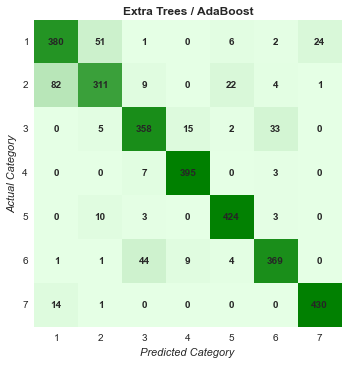

In [21]:
# With this result, what would happen if we attempted to aid the ExtraTrees classifier with 
# an AdaBoost classifier being applied on its result? 
clf1 = ExtraTreesClassifier(class_weight = weight_dict)
clf = AdaBoostClassifier(clf1)
clf = clf.fit(train_data, train_labels)
predictions = clf.predict(dev_data).astype(int)

print_diagnostics(dev_labels, predictions, "Extra Trees / AdaBoost")

This did not seem to make too much of a difference.   

In [28]:
#Now, let's optimize our model using a RandomizedSearchCV, 
#searching for the best parameters with which to test our model.
n_features = int(train_data.shape[1])

clf = ExtraTreesClassifier(class_weight = weight_dict)   

param_grid = { 
    "n_estimators" : sp_randint(10, 1000), 
    "max_features": sp_randint(0, n_features), 
    "min_samples_leaf": sp_randint(1, 10), 
    "min_samples_split": sp_randint(1, 10), 
    "bootstrap": ["True", "False"],
    "criterion": ["gini", "entropy"], 
} 

grid_search = RandomizedSearchCV(clf, n_iter=10, param_distributions=param_grid) 
grid_search.fit(train_data, train_labels) 
best_parameters = grid_search.best_params_ 

print best_parameters 

{'bootstrap': 'False', 'min_samples_leaf': 2, 'n_estimators': 707, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 28}


Classification report:
             precision    recall  f1-score   support

          1       0.80      0.79      0.79       464
          2       0.76      0.76      0.76       429
          3       0.84      0.89      0.87       413
          4       0.96      0.93      0.95       405
          5       0.95      0.95      0.95       440
          6       0.89      0.87      0.88       428
          7       0.96      0.96      0.96       445

avg / total       0.88      0.88      0.88      3024



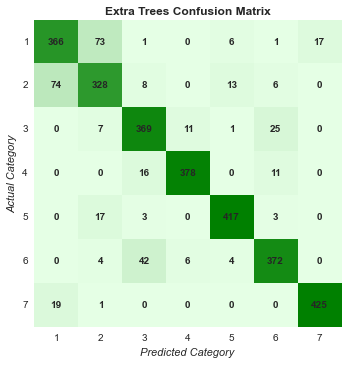

In [29]:
# Using the above values for the best parameters:
clf = ExtraTreesClassifier(bootstrap='False', min_samples_leaf=2, n_estimators=707, min_samples_split=3, 
                           criterion='entropy', max_features=28, class_weight=weight_dict)
clf.fit(train_data, train_labels)
predictions = clf.predict(dev_data).astype(int) 
print_diagnostics(dev_labels, predictions, "Extra Trees Confusion Matrix")

<strong> The final submission </strong>: Use the complete train and test data

In [37]:
# find the best parameters for the complete data
grid_search.fit(full_train_data_engd.values, full_train_labels.values) 
best_parameters = grid_search.best_params_ 

print best_parameters

{'bootstrap': 'False', 'min_samples_leaf': 1, 'n_estimators': 811, 'min_samples_split': 4, 'criterion': 'gini', 'max_features': 29}


In [38]:
# Using one of the combinations of the above values for the best parameters (due to RandomizedSearchCV, the values
# are different each time:
clf = ExtraTreesClassifier(bootstrap='False', min_samples_leaf=1, n_estimators=811, min_samples_split=4, 
                           criterion='gini', max_features=29, class_weight=weight_dict)
clf.fit(full_train_data_engd.values, full_train_labels.values)
predictions = clf.predict(full_test_data_engd.values).astype(int) 

submission = pd.DataFrame(full_test_id, columns = ['Id'])
submission['Cover_Type'] = predictions
submission.to_csv("SubmissionFinal.csv", index = False, index_col = False)

Final Kaggle score: 0.80403; rank: 162   

----

###Section 6: Results Summary and Reflection

Our baseline KNN model: Accuracy = 0.71016, Rank = 1175    
ExtraTrees model with feature engineering, tuning, and optimal parameters: Accuracy = 0.80403, Rank = 162   

At the end of the day, the team improved the accuracy against the test set by 0.09387 accuracy points (rank improvement of 1013 places).

While the team had considered adding more calculated features in order to discover relationships underlying the dataset, we ultimately settled on the final model as it would have potentially created concern for overfitting our model. Also, had time permitted, we would have liked to dive deeper into the skewed nature of the test set cover types, in comparison to the even spread of cover types in the training set.